In [1]:
import os; os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF


In [ ]:
import numpy as np
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import pandas as pd
import seaborn as sns
from scipy import stats

from grr.cell_class import Cell
from grr import pltools
from grr.Trace import Trace
from grr.Tools import getIndicesByPercentile

# Setup

In [3]:
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'fig1')
DATA_PATH = os.path.join('data', 'raw')
NOTEBOOK_PATH = os.path.join('figs', 'scripts', 'writeup')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

# Load data

In [4]:
# Short current step recordings.
short_fnames = {}
short_recs = {}
for cell_type in ['5HT', 'GABA']:
    short_fnames[cell_type] = pd.read_csv(os.path.join(DATA_PATH, cell_type, 'current_steps', 'index.csv'))
    short_recs[cell_type] = Cell().read_ABF(
        [os.path.join(DATA_PATH, cell_type, 'current_steps', fname_) for fname_ in short_fnames[cell_type]['Steps']]
    )
    for sr in short_recs[cell_type]:
        sr.set_dt(0.1)

# Long current step recordings.
long_fnames = {}
long_recs = {}
for cell_type in ['5HT', 'GABA']:
    long_fnames[cell_type] = pd.read_csv(os.path.join(DATA_PATH, cell_type, 'long_curr_steps', 'index.csv'))
    long_recs[cell_type] = Cell().read_ABF(
        [
            os.path.join(DATA_PATH, cell_type, 'long_curr_steps', fname_) 
            for fname_ in long_fnames[cell_type]['weak_steps']
            if isinstance(fname_, str)
        ]
    )
    for lr in long_recs[cell_type]:
        lr.set_dt(0.1)

In [5]:
short_fnames['5HT']

,Cell,R,C,hold,Steps
0,DRN159,707,43,-11.0,17n23013.abf
1,DRN160,365,79,-9.8,17n23017.abf
2,DRN162,485,57,-17.1,17n23022.abf
3,DRN163,1400,61,2.4,17n23027.abf
4,DRN164,919,39,-27.0,17n23034.abf
5,DRN165,759,63,-14.6,17n23038.abf
6,DRN196,923,74,-6.0,18111055.abf
7,DRN316,1200,40,-8.5,18420001.abf
8,DRN317,743,93,3.7,18420006.abf
9,DRN318,702,51,-8.0,18420025.abf


In [6]:
short_fnames['GABA']

,Cell,R,C,hold,Steps
0,DRN350,1700,42.0,-0.6,18711000.abf
1,DRN351,1600,38.0,-7.3,18711018.abf
2,DRN354,831,59.0,-8.5,18711033.abf
3,DRN355,960,36.0,-20.0,18711046.abf
4,DRN356,564,50.5,-5.5,18711060.abf
5,DRN357,552,55.0,-7.3,18711076.abf
6,DRN358,1200,38.0,10.0,18711091.abf
7,DRN421,836,71.0,-11.0,19114005.abf
8,DRN422,1400,57.0,13.4,19114022.abf
9,DRN424,1400,32.0,-9.8,19114045.abf


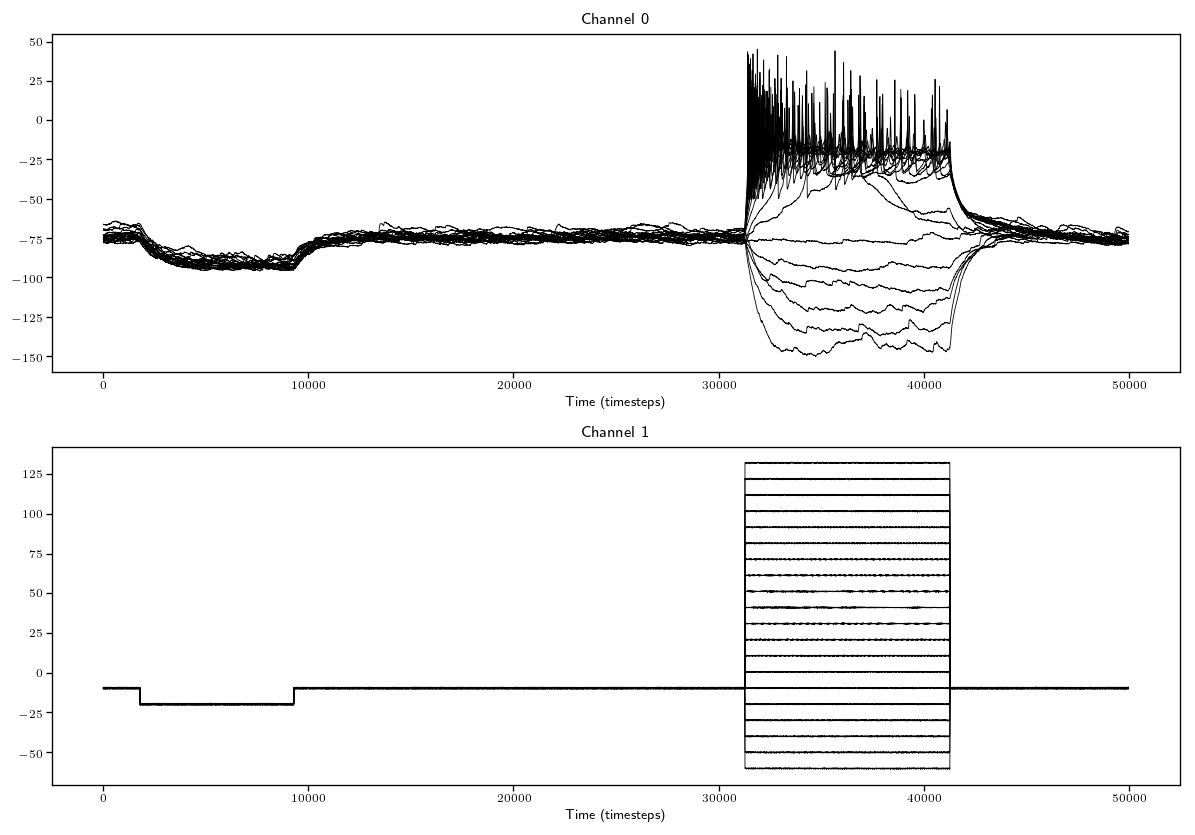

In [7]:
short_recs['GABA'][0].plot()

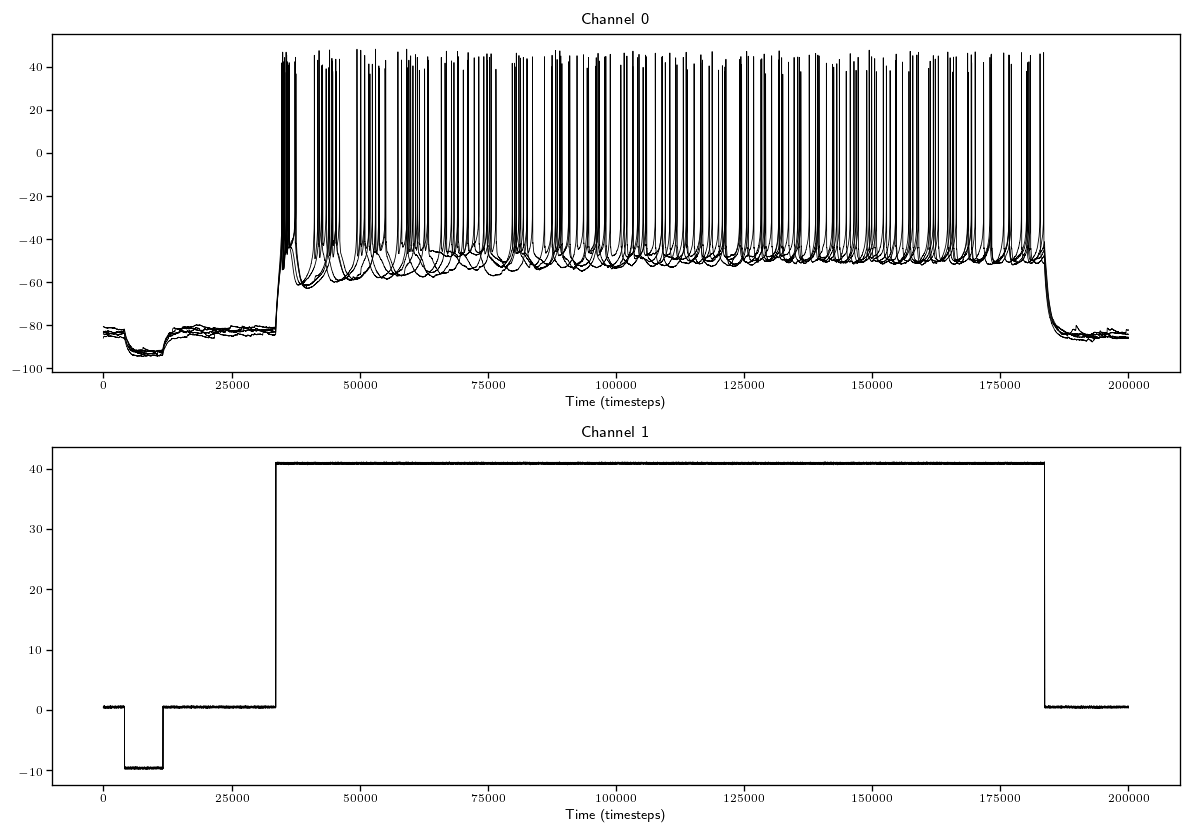

In [8]:
long_recs['5HT'][0].plot()

# Membrane parameters

Find test pulse range.

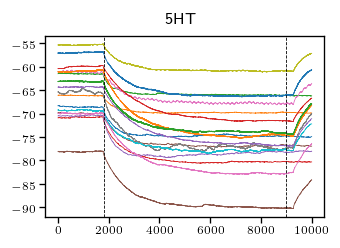

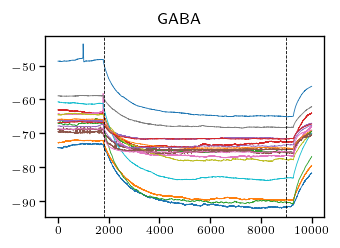

In [9]:
for cell_type in short_recs:
    plt.figure()
    plt.suptitle(cell_type)
    for i in range(len(short_recs[cell_type])):
        plt.plot(short_recs[cell_type][i].mean(axis=2)[0, :10000])
    plt.axvline(1800, ls='--')
    plt.axvline(9000, ls='--')
    plt.show()

Fit test pulse.

In [ ]:
membrane_params = {}
for cell_type in short_recs:
    membrane_params[cell_type] = pd.DataFrame()
    for i in range(len(short_recs[cell_type])):
        short_recs[cell_type][i].set_dt(0.1)
        tau_limits = getIndicesByPercentile(short_recs[cell_type][i][0, 1800:9000, :].mean(axis=1), [.8, .2])
        tmp_params = short_recs[cell_type][i].fit_test_pulse(
            (0, 1000), 
            (8000, 9000), 
            tau=(1800, tau_limits[0] + 1800, tau_limits[1] + 1800),
            V_clamp=False,
            V_chan=0,
            I_chan=1,
            plot_tau=True
        )
        tmp_params['R_input'] = np.mean(tmp_params['R_input'])  # Average R_in across sweeps.
        membrane_params[cell_type] = membrane_params[cell_type].append(tmp_params, ignore_index=True)
    
    membrane_params[cell_type] = membrane_params[cell_type].astype(np.float64)

Extracted parameters. R_input is in MOhm and tau is in ms. Note that some recordings have non-finite R_in, probably due to missing current channel.

In [11]:
membrane_params['5HT']

,R_input,tau
0,599.072605,58.211461
1,375.401167,33.652228
2,465.773718,30.057248
3,962.850821,69.716900
4,730.024899,39.610009
5,704.935221,78.999924
6,699.260615,76.446130
7,1183.130597,109.196593
8,551.129213,54.064363
9,834.994301,73.793340


In [12]:
membrane_params['5HT'].mean()

R_input    893.757170
tau         81.567164
dtype: float64

In [13]:
membrane_params['5HT'].sem()

R_input    72.994068
tau         8.347398
dtype: float64

In [12]:
membrane_params['GABA']

,R_input,tau
0,1793.160321,78.830090
1,1702.543980,102.845330
2,887.729193,90.213578
3,909.036181,39.113562
4,508.195696,42.118491
5,572.233780,46.390837
6,1209.847907,56.203347
7,906.909309,81.395213
8,1335.769825,77.956294
9,2216.512496,68.124219


In [22]:
print(membrane_params['GABA'].loc[np.isfinite(membrane_params['GABA']['R_input']), :].mean())
print('N = {}'.format(sum(np.isfinite(membrane_params['GABA']['R_input']))))

R_input    1193.122840
tau          62.452119
dtype: float64
N = 15


In [23]:
membrane_params['GABA'].loc[np.isfinite(membrane_params['GABA']['R_input']), :].sem()

R_input    154.492271
tau          6.303066
dtype: float64

## Compare membrane parameters between cell types

In [32]:
stats.mannwhitneyu(
    membrane_params['5HT']['R_input'], 
    membrane_params['GABA'].loc[np.isfinite(membrane_params['GABA']['R_input']), 'R_input'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=95.0, pvalue=0.2268904182195094)

In [31]:
stats.mannwhitneyu(
    membrane_params['5HT']['tau'], 
    membrane_params['GABA'].loc[np.isfinite(membrane_params['GABA']['R_input']), 'tau'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=172.0, pvalue=0.09660086735923616)

## Export membrane parameter plots

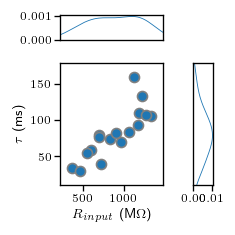

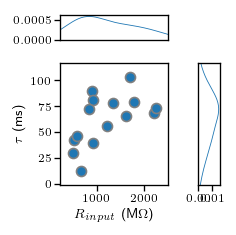

In [45]:
joint_spec = gs.GridSpec(2, 2, height_ratios=[0.2, 1], width_ratios=[1, 0.2])

for cell_type in membrane_params:
    mask = np.isfinite(membrane_params[cell_type]['R_input'])
    
    plt.figure(figsize=(2, 2))
    
    joint_ax = plt.subplot(joint_spec[1, 0])
    joint_ax.plot(
        membrane_params[cell_type]['R_input'][mask], 
        membrane_params[cell_type]['tau'][mask],
        'o', markeredgecolor='gray'
    )
    joint_ax.set_xlabel('$R_{input}$ (M$\Omega$)')
    joint_ax.set_ylabel(r'$\tau$ (ms)')
    joint_ax.margins(0.15)
    xlims = joint_ax.get_xlim()
    ylims = joint_ax.get_ylim()
    
    x_dist_ax = plt.subplot(joint_spec[0, 0])
    sns.kdeplot(membrane_params[cell_type]['R_input'][mask], legend=False, ax=x_dist_ax)
    x_dist_ax.set_xlim(xlims)
    x_dist_ax.set_xticks([])
    
    y_dist_ax = plt.subplot(joint_spec[1, 1])
    sns.kdeplot(membrane_params[cell_type]['tau'][mask], vertical=True, legend=False, ax = y_dist_ax)
    y_dist_ax.set_ylim(ylims)
    y_dist_ax.set_yticks([])
    y_dist_ax.set_ylabel('')
    
    plt.tight_layout()
    
    if IMG_PATH is not None:
        plt.savefig(os.path.join(IMG_PATH, '{}_membrane_params.png'.format(cell_type)), dpi=300)
        
    plt.show()

# Long current steps

## Export traces


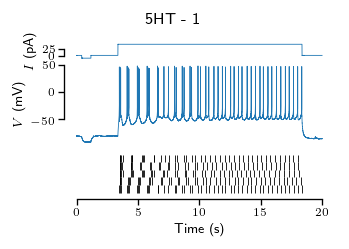

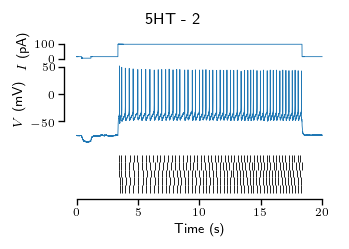

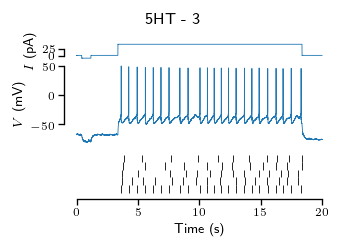

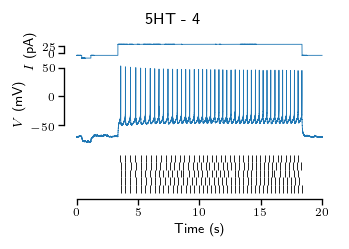

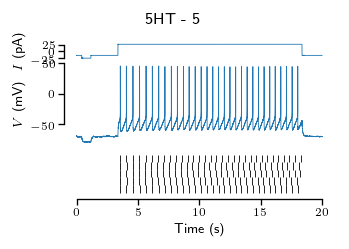

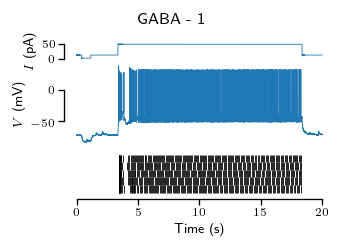

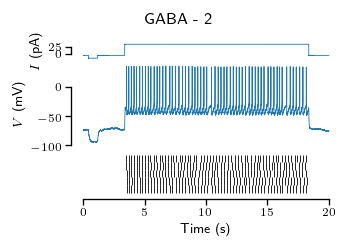

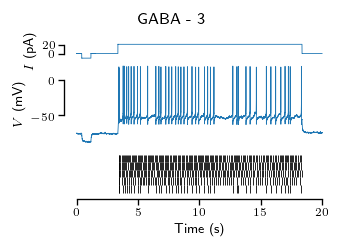

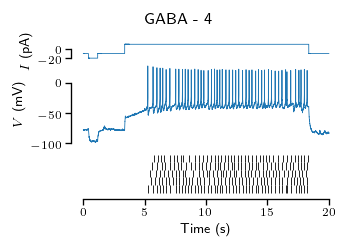

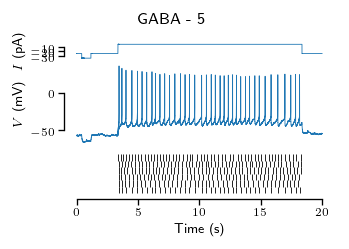

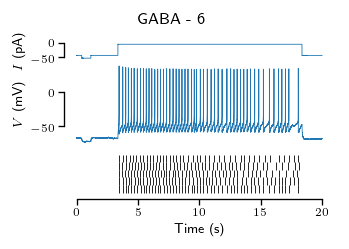

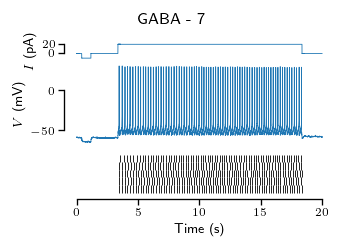

In [39]:
sample_sweep_no = 0

sample_trace_spec = gs.GridSpec(
    3, 1, height_ratios=[0.2, 1., 0.6], hspace=0.05, top=0.85, left=0.2, bottom=0.2, right=0.95
)

for cell_type in long_recs:
    for i, rec in enumerate(long_recs[cell_type]):
        
        plt.figure(frameon=False)
        
        plt.suptitle('{} - {}'.format(cell_type, i+1))
        
        plt.subplot(sample_trace_spec[0, :])
        plt.plot(rec.t_mat[0, :, sample_sweep_no] * 1e-3, rec[1, ...].mean(axis=1))
        plt.margins(0.05, 0.1)
        x_limits = plt.xlim()
        plt.xticks([])
        plt.ylabel('$I$ (pA)')
        sns.despine(bottom=True, trim=True, ax=plt.gca())
        
        plt.subplot(sample_trace_spec[1, :])
        plt.plot(rec.t_mat[1, :, sample_sweep_no] * 1e-3, rec[0, :, sample_sweep_no])
        plt.xlim(x_limits)
        plt.xticks([])
        plt.ylabel('$V$ (mV)')
        sns.despine(bottom=True, trim=True, ax=plt.gca())
        
        plt.subplot(sample_trace_spec[2, :])
        
        # Scrape spike times.
        spktimes = []
        for j in range(rec.shape[2]):
            tr_tmp = Trace(rec[0, :, j], rec[1, :, j], rec.shape[0] * rec.dt, rec.dt)
            tr_tmp.detectSpikes()
            spktimes.append(tr_tmp.getSpikeTimes() * 1e-3)
        
        plt.eventplot(spktimes)
        plt.xlim(x_limits)
        plt.yticks([])
        plt.xlabel('Time (s)')
        sns.despine(left=True, trim=True, ax=plt.gca())
        
        
        if IMG_PATH is not None:
            plt.savefig(os.path.join(IMG_PATH, '{}_{}_long_current_steps.png'.format(cell_type, i+1)))
            
        plt.show()

del tr_tmp, spktimes, cell_type, rec

In [19]:
rec.t_mat.shape

(2, 200000, 5)